In [1]:
import gdown

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [3]:
url='https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output='data.zip'

In [4]:
gdown.download(url,output,quiet=False)
gdown.extractall('data.zip')

Downloading...
From: https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
To: /content/data.zip
100%|██████████| 423M/423M [00:05<00:00, 84.1MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [5]:
def load_video(path:str)->List[float]:
  cap=cv2.VideoCapture(path)
  frames=[]
  for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret,frame=cap.read()
    frame=tf.image.rgb_to_grayscale(frame)
    frames.append(frame[190:236,80:220,:])
  cap.release()
  mean=tf.math.reduce_mean(frames)
  std=tf.math.reduce_std(tf.cast(frames,tf.float32))
  return tf.cast((frames-mean),tf.float32)/std

In [6]:
vocab=[x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789"]

In [7]:
char_to_num=tf.keras.layers.StringLookup(vocabulary=vocab,oov_token="")
num_to_char=tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(),oov_token="",invert=True)
print(f"The vocabulary is:{char_to_num.get_vocabulary()}")
print(f"(size={char_to_num.vocabulary_size()})")

The vocabulary is:['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9']
(size=39)


In [8]:
char_to_num(['a','b','c'])

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([1, 2, 3])>

In [9]:
num_to_char([14,9,10])

<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'n', b'i', b'j'], dtype=object)>

In [10]:
def load_alignments(path: str) -> tf.Tensor:
    with open(path, 'r') as f:
        lines = f.readlines()

    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens.extend([' ', line[2]])
    tokens_tensor = tf.constant(tokens, dtype=tf.string)
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens_tensor, input_encoding='UTF-8'), shape=(-1,)))

In [11]:
a=load_alignments('data/alignments/s1/bbaf2n.align')

In [12]:
a

<tf.Tensor: shape=(22,), dtype=int64, numpy=
array([ 0,  2,  9, 14,  0,  2, 12, 21,  5,  0,  1, 20,  0,  6,  0, 20, 23,
       15,  0, 14, 15, 23])>

In [13]:
def load_data(path: str):
    path_str = bytes.decode(path.numpy())
    file_name = path_str.split('/')[-1].split('.')[0]
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments','s1', f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments


In [14]:
test_path='data/alignments/s1/bbaf2n.align'

In [15]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbaf2n'

In [16]:
frames,alignments=load_data(tf.convert_to_tensor(test_path))

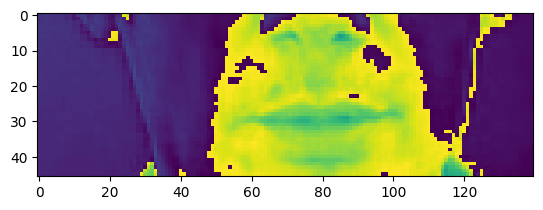

In [17]:
plt.imshow(frames[10])

In [18]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'binblueatftwonow'>

In [19]:
alignments

<tf.Tensor: shape=(22,), dtype=int64, numpy=
array([ 0,  2,  9, 14,  0,  2, 12, 21,  5,  0,  1, 20,  0,  6,  0, 20, 23,
       15,  0, 14, 15, 23])>

In [20]:
def mappable_function(path:str)->List[str]:
  result=tf.py_function(load_data,[path],(tf.float32,tf.int64))
  return result

In [21]:
data=tf.data.Dataset.list_files('data/s1/*.mpg')
#data=data.shuffle(500)

In [22]:
data.as_numpy_iterator().next()

b'data/s1/bwaazn.mpg'

In [23]:
data=data.shuffle(500)

In [24]:
data=data.map(mappable_function)

In [25]:
frames,alignments=data.as_numpy_iterator().next()

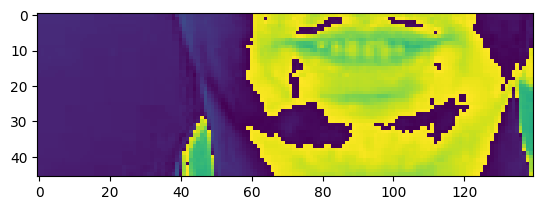

In [26]:
plt.imshow(frames[50])

In [27]:
data=data.padded_batch(2,padded_shapes=([75,None,None,None],[40]))
data=data.prefetch(tf.data.AUTOTUNE)

In [28]:
train=data.take(450)
test=data.skip(450)

In [29]:
frames,alignments=data.as_numpy_iterator().next()

In [30]:
alignments

array([[ 0, 16, 12,  1,  3,  5,  0,  2, 12, 21,  5,  0,  9, 14,  0,  2,
         0,  5,  9,  7,  8, 20,  0, 16, 12,  5,  1, 19,  5,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  2,  9, 14,  0,  7, 18,  5,  5, 14,  0,  1, 20,  0, 20,  0,
         5,  9,  7,  8, 20,  0, 14, 15, 23,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [31]:
alignments[0].shape

(40,)

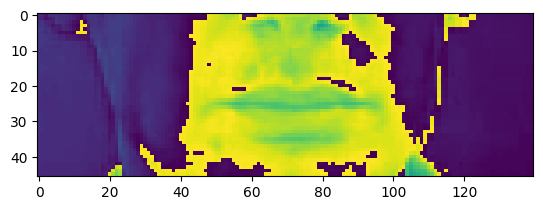

In [32]:
plt.imshow(frames[1][74])#we have padded to 2 set of frames and alignments

In [33]:
test=data.as_numpy_iterator()

In [34]:
val=test.next()

In [35]:
val[0][1].shape

(75, 46, 140, 1)

In [36]:
from PIL import Image
image_array = val[0][1].squeeze()  # Remove singleton dimensions
image_array = (image_array * 255).astype(np.uint8)

# Replicate the single channel to create an RGB image
rgb_image_array = np.repeat(image_array, 3, axis=-1)

# Create a list to store individual frames
frames = []

# Iterate through the frames and append to the list
for frame_data in rgb_image_array:
    # Convert each frame to a Pillow Image
    pil_frame = Image.fromarray(frame_data, mode='L')  # 'RGB' for color
    frames.append(pil_frame)

# Save the frames as a GIF
output_path = '/content/data/animation.gif'
imageio.mimsave(output_path, frames, fps=10)

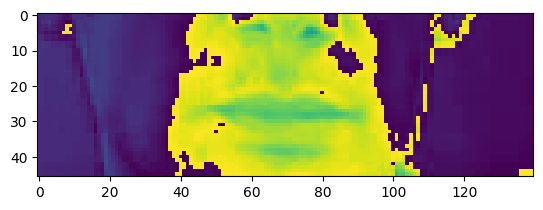

In [37]:
plt.imshow(val[0][0][0])
#0 1st for videos and 1 for alignment
#0 2nd for 1st video
#0 3rd for 1st frame

#Deep Learning Model

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D,LSTM,Dense,Dropout,Bidirectional,Activation,MaxPool3D,TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler

In [39]:
model=Sequential()
model.add(Conv3D(128,3,input_shape=(75,46,140,1),padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256,3,padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75,3,padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(tf.keras.layers.Flatten()))

model.add(Bidirectional(LSTM(128,kernel_initializer='Orthogonal',return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128,kernel_initializer='Orthogonal',return_sequences=True)))
model.add(Dropout(0.5))

model.add(Dense(char_to_num.vocabulary_size()+1,kernel_initializer='he_normal',activation='softmax'))


In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [41]:
yhat=model.predict(val[0])

1/1 [==============================] - 7s 7s/step


In [42]:
 [num_to_char(x) for x in tf.argmax(yhat[0],axis=1)]

[<tf.Tensor: shape=(), dtype=string, numpy=b'3'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'3'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b's'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b's'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b's'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b's'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b's'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b's'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b's'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b's'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b's'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b's'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b's'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b's'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b's'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'3'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'3'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'3'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'3'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'3'>,


In [43]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'33sssssssssssss3333333333333333333333333333333333333333333333333333333fffff'>

In [44]:
model.input_shape

(None, 75, 46, 140, 1)

In [45]:
model.output_shape

(None, 75, 40)

In [46]:
def scheduler(epoch,lr):
  if epoch <30:
    return lr
  else:
    return lr*tf.math.exp(-0.1)

In [47]:
def CTCLoss(y_true,y_pred):
  batch_len=tf.cast(tf.shape(y_true)[0],dtype='int64')
  input_length=tf.cast(tf.shape(y_pred)[1],dtype='int64')
  label_length=tf.cast(tf.shape(y_true)[1],dtype='int64')

  input_length=input_length*tf.ones(shape=(batch_len,1),dtype='int64')
  label_length=label_length*tf.ones(shape=(batch_len,1),dtype='int64')

  loss=tf.keras.backend.ctc_batch_cost(y_true,y_pred,input_length,label_length)
  return loss

In [48]:
class ProduceExample(tf.keras.callbacks.Callback):
  def __init__(self,dataset)->None:
    self.dataset=dataset.as_numpy_iterator()
  def on_epoch_end(self,epoch,logs=None)->None:
    data=self.dataset.next()
    yhat=self.model.predict(data[0])
    decoded=tf.keras.backend.ctc_decode(yhat,[75,75],greedy=False)[0][0].numpy()
    for x in range(len(yhat)):
      print('Original',tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
      print('Predicted',tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
      print('~'*100)

In [49]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss=CTCLoss)

In [50]:
checkpoint_callback=ModelCheckpoint(os.path.join('models','checkpoint'),monitor='loss',save_weights_only=True)

In [51]:
schedule_callback=LearningRateScheduler(scheduler)

In [52]:
example=ProduceExample(data)

In [ ]:
model.fit(train,validation_data=test,epochs=100,callbacks=[checkpoint_callback,schedule_callback,example])

Epoch 1/100
1/1 [==============================] - 2s 2s/step
Original placebluewithpeightplease
Predicted eeeee
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original layredbyrfivesoon
Predicted eeeee
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 893s 2s/step - loss: 84.8560 - val_loss: 70.1722 - lr: 1.0000e-04
Epoch 2/100
450/450 [==============================] - ETA: 0s - loss: 70.6721

1/1 [==============================] - 0s 263ms/step
Original bingreenathonesoon
Predicted laeeeoo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original setredwithitwonow
Predicted laeeeeo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 480s 1s/step - loss: 70.6721 - lr: 1.0000e-04
Epoch 3/100
1/1 [==============================] - 0s 305ms/step
Original placeredwithqfiveagain
Predicted laeeeeo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original placewhiteatqzeronow
Predicted laeeeeo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 476s 1s/step - loss: 66.6429 - lr: 1.0000e-04
Epoch 4/100
1/1 [==============================] - 0s 254ms/step
Original bingreenatuzeroplease
Predicted laeet